# 加载数据

In [1]:
%matplotlib inline
from datasets import D2LBananaDatasets
from anchor_box import DetectAnchorBoxGenerator, DetectAnchorBoxMatcher, Box, to_box, gen_multi_layer_anchor_sample

d2l_banana_ds = D2LBananaDatasets("./data")

test_images, test_labels = d2l_banana_ds.load_test_dataset()

image=test_images[0]
label=test_labels[0]
height=image.shape[0]
width=image.shape[1]
channel=image.shape[2]

# 锚框生成

generate boxes count: 10


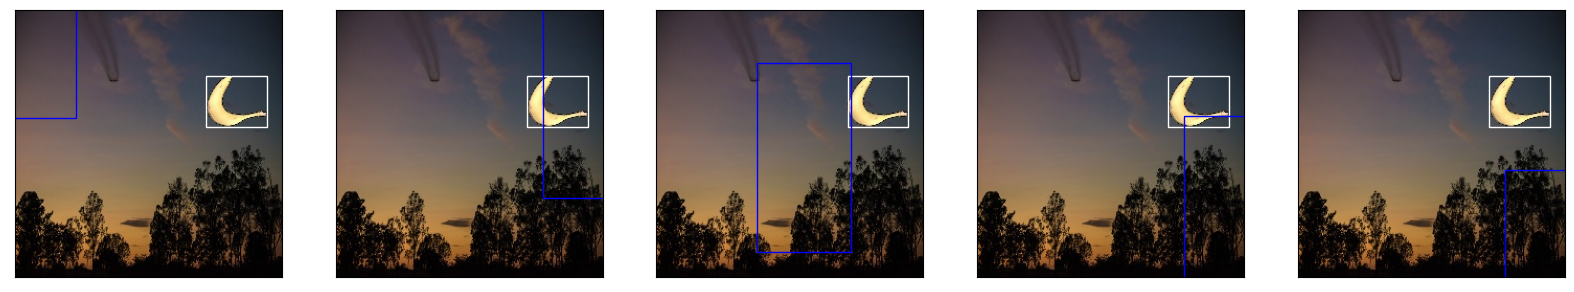

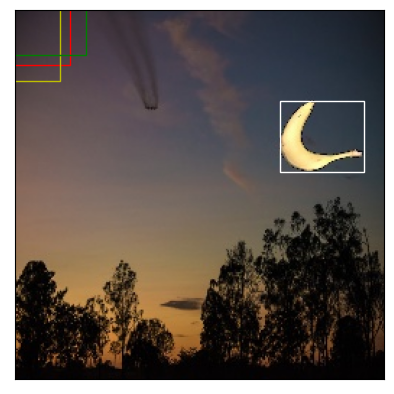

batch generate box shape: (32, 32, 5, 4)


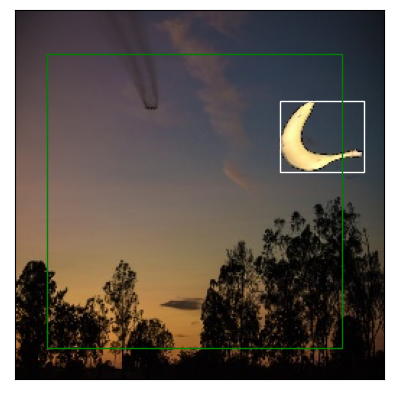

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20.0, 20.0))

boxes=DetectAnchorBoxGenerator().generate(height, width, 10, 10, 0.5, 0.5)
print(f"generate boxes count: {len(boxes)}")
show_indexs=[(0, 0), (3, 9), (5, 5), (7, 9), (9, 9)]
i = 0
for idx in show_indexs:
    box=to_box(boxes[idx[0]][idx[1]])
    plt.subplot(1, 5, i + 1)
    d2l_banana_ds.draw_image(image, label)
    box.draw(color="b")
    i += 1
plt.show()


plt.figure()
d2l_banana_ds.draw_image(image, label)
boxes=DetectAnchorBoxGenerator().generate(height, width, 10, 10, 0.2, 1)
to_box(boxes[0][0]).draw(color="r")
boxes=DetectAnchorBoxGenerator().generate(height, width, 10, 10, 0.2, 0.5)
to_box(boxes[0][0]).draw(color="y")
boxes=DetectAnchorBoxGenerator().generate(height, width, 10, 10, 0.2, 2)
to_box(boxes[0][0]).draw(color="g")
plt.show()

scales=[0.2, 0.5, 0.8]
aspect_ratios=[1, 2, 0.5]
boxes=DetectAnchorBoxGenerator().batch_generate(height, width, 32, 32, scales, aspect_ratios)
print(f"batch generate box shape: {np.array(boxes).shape}")

plt.figure()
d2l_banana_ds.draw_image(image, label)
to_box(boxes[16][15][2]).draw(color="g")
plt.show()

# 锚框IOU

In [3]:
from anchor_box import Box

a=Box(0, 0, 10, 10)
b=Box(5, 8, 20, 100)
c=Box(10, 10, 100, 100)

print(f"box a {a}")
print(f"box b {b}")
print(f"box c {c}")


print(f"iou of (a, a) is {a.calc_iou(a)}")
print(f"iou of (a, b) is {a.calc_iou(b)}")
print(f"iou of (a, c) is {a.calc_iou(c)}")

box a (0, 0, 10, 10)
box b (5, 8, 20, 100)
box c (10, 10, 100, 100)
iou of (a, a) is 1.0
iou of (a, b) is 0.006802721088435374
iou of (a, c) is 0.0


# 锚框偏移量计算

In [4]:
a=Box(0, 0, 10, 10)
b=Box(5, 5, 20, 20)
m=DetectAnchorBoxMatcher()
box_offset=m.calc_box_offset(a, b)
recover_box=m.anchor_to_label_box(a, box_offset)

print(f"box a {a}")
print(f"box b {b}")
print(f"box_offset {box_offset}")
print(f"recover_box {recover_box}")

box a (0, 0, 10, 10)
box b (5, 5, 20, 20)
box_offset (7.5, 7.5, 2.027325573874155, 2.027325573874155)
recover_box (4.99999995, 4.99999995, 20.00000005, 20.00000005)


# 锚框的标注

100
nms max cls 1 i 38
idx 38 anchor (192, 64, 243, 115) offset (-1.0784313725490196, -0.39215686274509803, 0.6430869330759845, -0.20002662102767935) mask [1.0, 1.0, 1.0, 1.0]


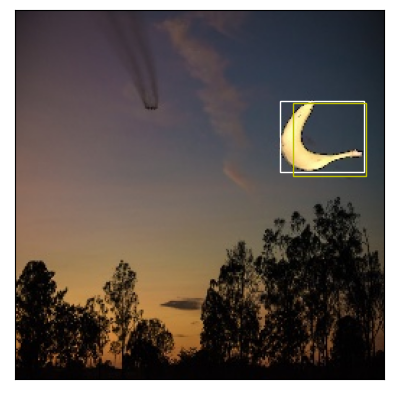

all 100 match 4.0


In [5]:
import numpy as np
import matplotlib.pyplot as plt

anchors=DetectAnchorBoxGenerator().generate(height, width, 10, 10, 0.2, 1)
anchors=[to_box(i) for i in np.array(anchors).reshape((-1, 4))]
print(len(anchors))
label_boxes=[to_box(label)]
box_offsets, box_masks, class_labels=DetectAnchorBoxMatcher(0.6).match_label_boxes(anchors, label_boxes)


plt.figure()
d2l_banana_ds.draw_image(image, label)

for i in range(len(class_labels)):
    if class_labels[i] <= 0:
        continue
    print(f"idx {i} anchor {anchors[i]} offset {box_offsets[i]} mask {box_masks[i]}")
    anchors[i].draw(color="y")
plt.show()
print(f"all {len(box_masks)} match {np.sum(box_masks)}")

# NMS筛选预测边框

In [6]:
predict_boxes=[
    Box(0, 0, 10, 10),
    Box(1, 1, 99, 99),
    Box(2, 1, 9, 9),
    Box(3, 3, 100, 100)
]
predict_probs=[
    0.3,
    0.3,
    0.4,
    0.4
]
predict_classes=np.ones(shape=(4, 1))
boxes, cls=DetectAnchorBoxMatcher().nms_predict_boxes(predict_boxes, predict_probs, predict_classes)
print("nms result:")
for b in boxes:
    print(b)

nms result:
(3, 3, 100, 100)
[1.]


# 将样本转成训练的数据集

nms max cls 1 i 1384
5444
(5444, 4)
(5444, 4)
(5444, 4)
(5444, 2)


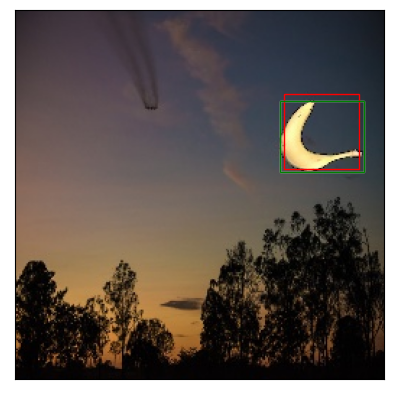

row 10.8125, col 26.0
box_offsets [ 0.          0.67307692  0.5459965  -0.29711705]


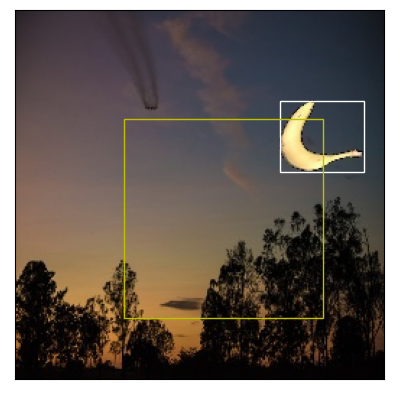

In [7]:
import matplotlib.pyplot as plt
import numpy as np

label_boxes=[to_box(label)]
layer_params=[
    {
        "h": 32,
        "w": 32,
        "scales": [0.2, 0.272],
        "aspect_ratios": [1, 0.5, 2]
    },
    {
        "h": 16,
        "w": 16,
        "scales": [0.37, 0.447],
        "aspect_ratios": [1, 0.5, 2]
    },
    {
        "h": 8,
        "w": 8,
        "scales": [0.54, 0.619],
        "aspect_ratios": [1, 0.5, 2]
    },
    {
        "h": 4,
        "w": 4,
        "scales": [0.71, 0.79],
        "aspect_ratios": [1, 0.5, 2]
    },
    {
        "h": 1,
        "w": 1,
        "scales": [0.88, 0.961],
        "aspect_ratios": [1, 0.5, 2]
    },
]
anchors, box_offsets, box_masks, class_labels=gen_multi_layer_anchor_sample(height, width, label_boxes, layer_params)
print(len(anchors))
print(anchors.shape)
print(box_offsets.shape)
print(box_masks.shape)
print(class_labels.shape)

for i in range(len(anchors)):
    if np.sum(box_masks[i]) <= 0:
        continue
    plt.figure()
    d2l_banana_ds.draw_image(image, label)
    box=to_box(anchors[i])
    box.draw("r")
    label_box=m.anchor_to_label_box(box, box_offsets[i])
    label_box.draw("g")
    plt.show()
    idx = i / 4
    print(f"row {idx / 32}, col {idx % 32}")
    print(f"box_offsets {box_offsets[i]}")
row=4
col=4
idx=32 * 32 + 16 * 16 + row * 8 + col
idx*=4
plt.figure()
d2l_banana_ds.draw_image(image, label)
to_box(anchors[idx]).draw("y")
plt.show()